<a href="https://colab.research.google.com/github/HarshithSaiArjun/FlowerSpeciesDetection/blob/main/flower_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the Flowers dataset
(ds_train, ds_test), ds_info = tfds.load('tf_flowers',
                                         split=['train[:80%]', 'train[80%:]'],
                                         as_supervised=True,
                                         with_info=True)

# Define a function to normalize and resize the images
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0
    return image, label

# Apply the preprocessing to training and test data
ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [ ]:
# Apply augmentation to the training data
ds_train_augmented = ds_train.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Use MobileNetV2 as a base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Freeze the base model layers
base_model.trainable = False

# Add a custom head for classification
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and learning rate scheduling
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model for more epochs
history = model.fit(ds_train_augmented, epochs=5, validation_data=ds_test, callbacks=[early_stopping, lr_scheduler])

# Unfreeze the last few layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(ds_train_augmented, epochs=5, validation_data=ds_test)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(ds_test)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 194ms/step - accuracy: 0.7268 - loss: 0.7527 - val_accuracy: 0.8815 - val_loss: 0.3661 - learning_rate: 0.0010
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.9083 - loss: 0.2465 - val_accuracy: 0.8719 - val_loss: 0.3780 - learning_rate: 0.0010
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9163 - loss: 0.2205 - val_accuracy: 0.8856 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9395 - loss: 0.1772 - val_accuracy: 0.8842 - val_loss: 0.3829 - learning_rate: 0.0010
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9491 - loss: 0.1555 - val_accuracy: 0.8978 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 238ms/step - accuracy: 0.9325 - loss: 0.1896 - val_accuracy: 0.9005 - val_loss: 0.3495
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.9467 - loss: 0.1461 - val_accuracy: 0.8965 - v

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(ds_test)
print(f'Test Accuracy: {test_acc:.4f}')


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9036 - loss: 0.3571
Test Accuracy: 0.8992


In [ ]:
!pip install matplotlib scikit-learn


In [ ]:
import numpy as np  # Import numpy and assign it to the alias 'np'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # import matplotlib

# Make predictions on the test set
y_pred = model.predict(ds_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels
y_true = np.concatenate([y for x, y in ds_test])  # Get the true class labels

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


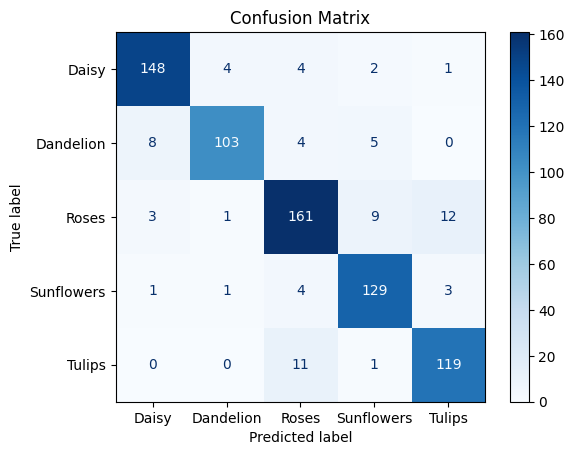

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Daisy", "Dandelion", "Roses", "Sunflowers", "Tulips"])
disp.plot(cmap=plt.cm.Blues) # use plt alias to access matplotlib functions
plt.title('Confusion Matrix') # use plt alias to access matplotlib functions
plt.show() # use plt alias to access matplotlib functions

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
# Define the mapping of class indices to flower names
class_names = ["Daisy", "Dandelion", "Roses", "Sunflowers", "Tulips"]

# List of new image paths (replace with your image paths)
new_image_paths = ['/content/image1.jpg', '/content/image2.jpg']

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize to 128x128
    img = image.img_to_array(img) / 255.0  # Convert to array and normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Make predictions and print class names
for img_path in new_image_paths:
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    print(f"Predicted class for {img_path}: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class for /content/image1.jpg: Dandelion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class for /content/image2.jpg: Tulips
